In [1]:
import sys
sys.path.append('nam')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import torch

In [4]:
from itertools import combinations

In [5]:
import numpy as np
import pandas as pd
import sklearn.metrics as sk_metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import random_split

from nam.wrapper import NAMClassifier, MultiTaskNAMClassifier

/mnt/idms/kdomokos/ericcson/rishap/supplementary/nam/nam/nam/trainer/trainer.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [6]:
random_state = 2016

In [7]:
import data_utils
data_x, data_y, columns = data_utils.load_dataset("Recidivism")
original_dfs = data_utils.load_recidivism_data()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=random_state)

In [9]:
device="cuda:7"

In [10]:
%%time
single_models = []
for i in range(len(columns)):
    X_train_f = X_train[:, i:i+1]
    X_test_f = X_test[:, i:i+1]
    model = NAMClassifier(
        num_epochs=1000,
        num_learners=20,
        metric='auroc',
        early_stop_mode='max',
        monitor_loss=False,
        n_jobs=10,
        random_state=random_state,
        device=device
    )

    model.fit(X_train_f, y_train)
    pred = model.predict_proba(X_test_f)
    print(columns[i], sk_metrics.roc_auc_score(y_test, pred))
    single_models.append(model)

age 0.6012683218346646
race 0.5735968155891
sex 0.5393249134264966
priors_count 0.6194020692267879
length_of_stay 0.5006402970978534
c_charge_degree 0.5686478526036081
CPU times: user 48 s, sys: 5.24 s, total: 53.3 s
Wall time: 1min 46s


In [11]:
%%time
double_models = {}
for i,j in combinations(range(len(columns)), 2):
    X_train_f = X_train[:, [i,j]]
    X_test_f = X_test[:, [i,j]]
    model = NAMClassifier(
        num_epochs=1000,
        num_learners=20,
        metric='auroc',
        early_stop_mode='max',
        monitor_loss=False,
        n_jobs=10,
        random_state=random_state,
        device=device
    )

    model.fit(X_train_f, y_train)
    pred = model.predict_proba(X_test_f)
    print(columns[i], columns[j], sk_metrics.roc_auc_score(y_test, pred))
    double_models[(i,j)] = model

age race 0.6205892867623911
age sex 0.6391152161269495
age priors_count 0.7430861252954705
age length_of_stay 0.5690560420034896
age c_charge_degree 0.6433625202093771
race sex 0.5820940916585295
race priors_count 0.6812120824062364
race length_of_stay 0.5421635638936466
race c_charge_degree 0.5915864961342063
sex priors_count 0.6872682257900998
sex length_of_stay 0.5710169518656656
sex c_charge_degree 0.5876033146046432
priors_count length_of_stay 0.666071723946578
priors_count c_charge_degree 0.6851339021305886
length_of_stay c_charge_degree 0.6013830417313634
CPU times: user 2min 39s, sys: 12.1 s, total: 2min 51s
Wall time: 7min 18s


In [13]:
%%time
full_model = NAMClassifier(
    num_epochs=1000,
    num_learners=20,
    metric='auroc',
    early_stop_mode='max',
    monitor_loss=False,
    n_jobs=10,
    random_state=random_state,
    device=device
)

full_model.fit(X_train, y_train)
pred = full_model.predict_proba(X_test)
sk_metrics.roc_auc_score(y_test, pred)

CPU times: user 9.62 s, sys: 1.02 s, total: 10.6 s
Wall time: 59.1 s


0.7447055433721246

In [39]:
titles = {
    'age':'Age', 'race':'Race', 'sex':'Gender', 'priors_count':'Priors Count', 'length_of_stay': 'Length of Stay', 'c_charge_degree': 'Charge Degree',
}
xticks = {
    'sex': {'labels':['Female', 'Male']},
    'race': {'labels': ["African\nAmerican", 'Asian', 'Caucasian', 'Hispanic', "Native\nAmerican", 'Other'], 'rotation':90}
}
def special_step(*args, **kwargs):
    x,y,*z = args
    x0 = 2*x[0]-x[1]
    xn = 2*x[-1]-x[-2]
    xx = np.concatenate([[x0], x, [xn]])
    yy = np.concatenate([[y[0]], y, [y[-1]]])
    plt.step(xx, yy, *z, **kwargs)
    plt.xlim((xx[0]+xx[1])/2, (xx[-2]+xx[-1])/2)

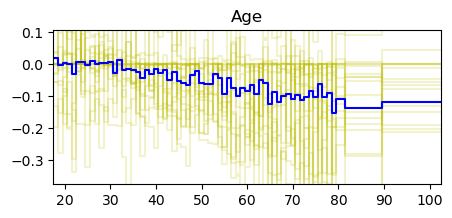

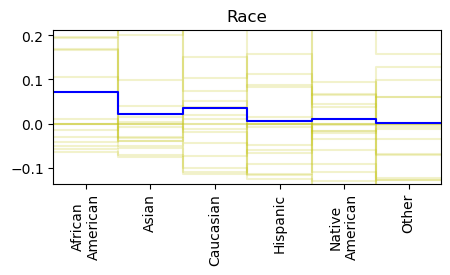

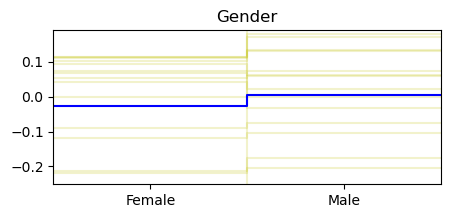

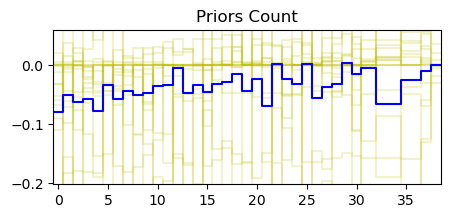

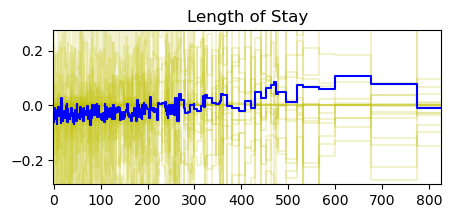

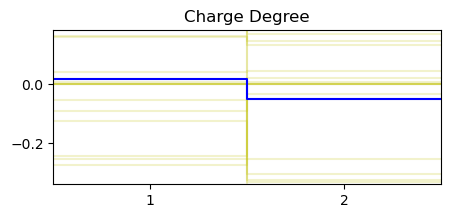

In [71]:
with torch.no_grad():
    for i, (model, colname) in enumerate(zip(single_models, columns)):
        vX = np.sort(original_dfs['X'][colname].unique())
        X = np.zeros((len(vX), 1))
        X[:, 0] = np.sort(np.unique(data_x[:, i]))
        lines = []
        model = single_models[i]
        for m in model.models:
            out = m.forward(torch.tensor(X, dtype=torch.float32))[1][:,0]
            lines.append(out.cpu().numpy())
        plt.figure(figsize=(5,2))
        plt.tight_layout()
        plt.title(titles[colname])
        for l in lines:
            special_step(vX, l, color='y', alpha=0.2, where='mid')
        special_step(vX, np.mean(lines, axis=0), color='b', linestyle='-', where='mid')
        
        if colname in xticks:
            plt.xticks(vX, **xticks[colname])
        elif len(vX) < 10:
            plt.xticks(vX)
        plt.ylim(
            np.percentile(lines, 20, axis=0).min()-np.abs(np.percentile(lines, 20, axis=0).min()*0.1),
            np.percentile(lines, 80, axis=0).max()+np.abs(np.percentile(lines, 80, axis=0).max()*0.1),
        )
        plt.savefig('out/recidivism_solo_%d.png'%i)
        plt.show()

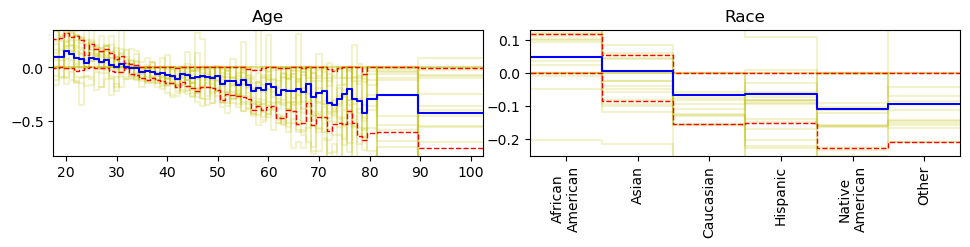

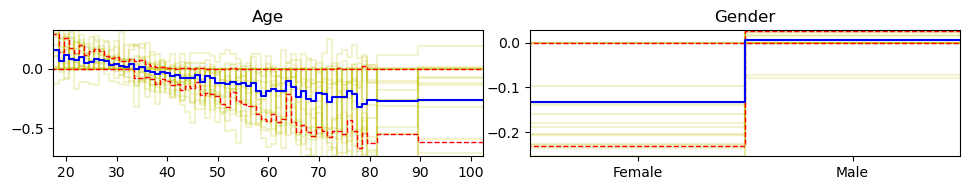

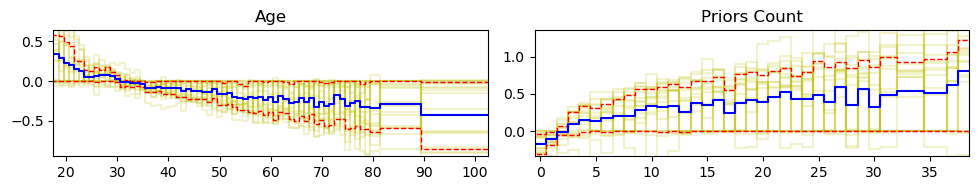

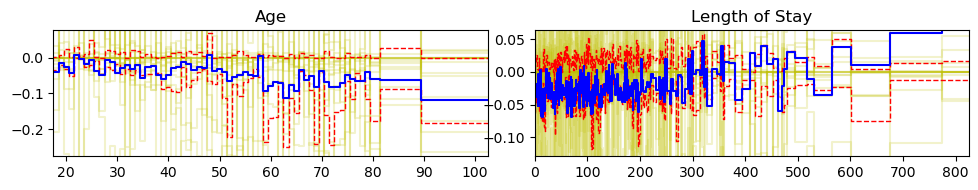

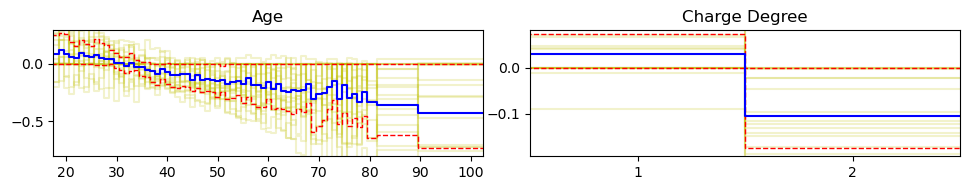

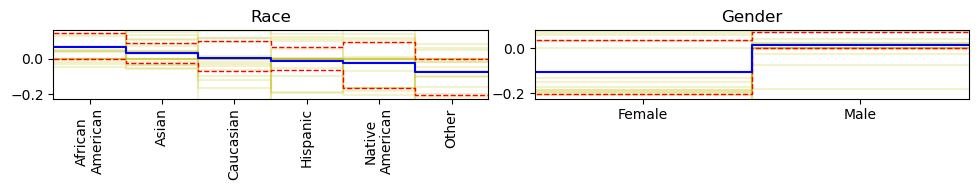

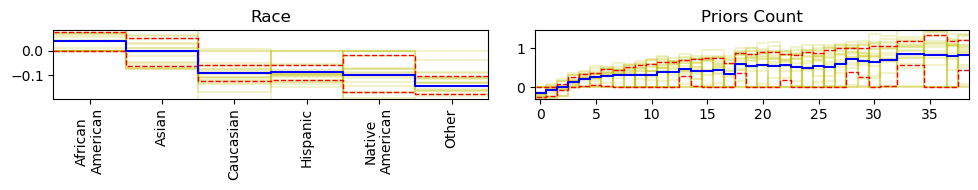

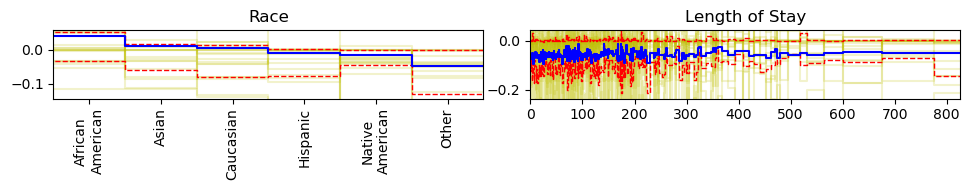

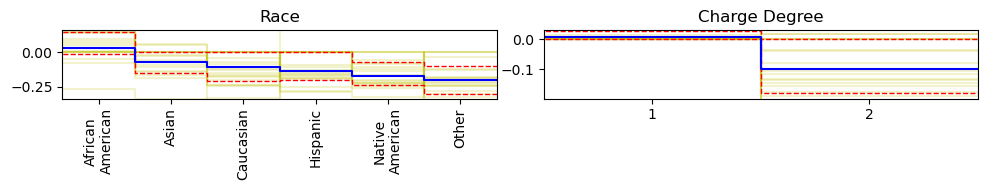

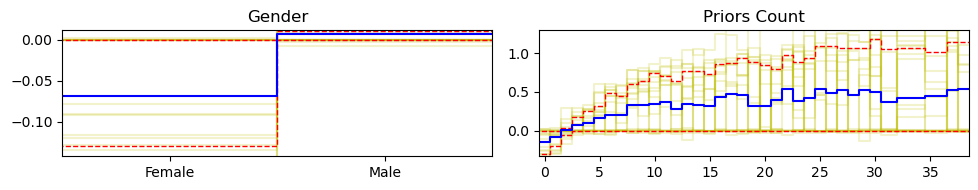

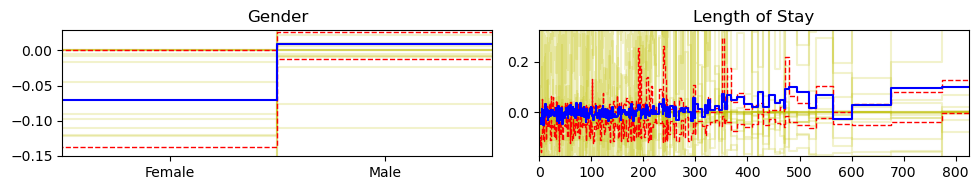

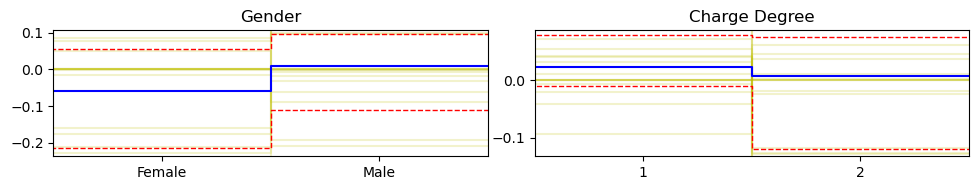

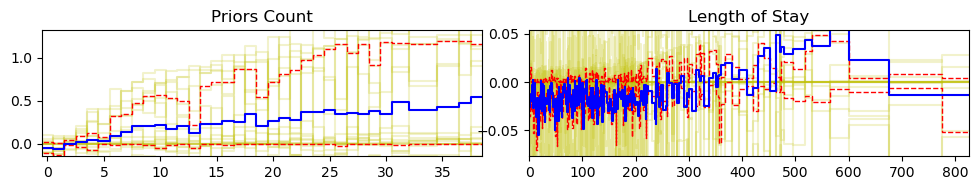

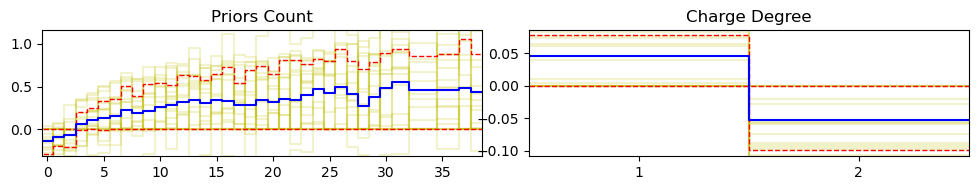

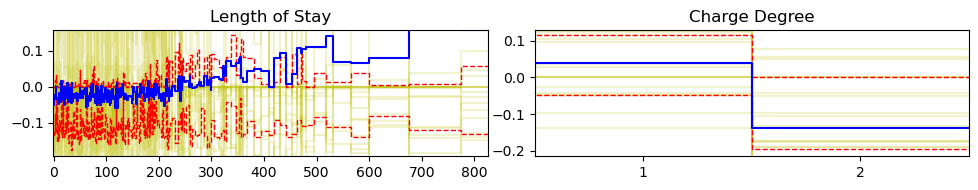

In [63]:
with torch.no_grad():
    for z, (j,k) in enumerate(combinations(range(len(columns)), 2)):
        two_cols = [columns[j], columns[k]]
        model = double_models[(j,k)]
        plt.figure(figsize=(10,2))
        for i, colname in zip(range(len(two_cols)), two_cols):
            vX = np.sort(original_dfs['X'][colname].unique())
            X = np.zeros((len(vX), 2))
            X[:, i] = np.sort(np.unique(data_x[:, [j,k][i]]))
            lines = []
            for m in model.models:
                out = m.forward(torch.tensor(X, dtype=torch.float32))[1][:,i]
                lines.append(out.cpu().numpy())
                
            plt.subplot(1, 2, i+1)
            plt.tight_layout()
            plt.title(titles[colname])
            for l in lines:
                special_step(vX, l, color='y', alpha=0.2, where='mid')
            special_step(vX,  np.percentile(lines, 80, axis=0), color='r', linestyle='--', lw=1, where='mid')
            special_step(vX,  np.percentile(lines, 20, axis=0), color='r', linestyle='--', lw=1, where='mid')
            special_step(vX, np.mean(lines, axis=0), color='b', linestyle='-', where='mid')

            #plt.xlim(vX.min(), vX.max())
            if colname in xticks:
                plt.xticks(vX, **xticks[colname])
            elif len(vX) < 10:
                plt.xticks(vX)
            plt.ylim(
                np.percentile(lines, 20, axis=0).min()-np.abs(np.percentile(lines, 20, axis=0).min()*0.1),
                np.percentile(lines, 80, axis=0).max()+np.abs(np.percentile(lines, 80, axis=0).max()*0.1),
            )
            #plt.show()
        plt.savefig("out/recidivism_double_%d.png"%z)

In [72]:
full_logit = full_model.predict(X_train)
single_logits = [m.predict(X_train[:,[i]]) for i, m in enumerate(single_models)]
double_logits = {k: m.predict(X_train[:, k]) for k, m in double_models.items()}

In [73]:
for i, pred in enumerate(single_logits):
    print(columns[i], sk_metrics.roc_auc_score(full_logit, pred))

age 0.5
race 0.5516517018499062
sex 0.5198021141783679
priors_count 0.5
length_of_stay 0.5005540166204986
c_charge_degree 0.5113655660627674


In [74]:
for (i,j), pred in double_logits.items():
    print(columns[i], columns[j], sk_metrics.roc_auc_score(full_logit, pred))

age race 0.6098499803653112
age sex 0.5092252081100109
age priors_count 0.8300620350028126
age length_of_stay 0.5
age c_charge_degree 0.5550370051970015
race sex 0.6658788911176914
race priors_count 0.8253327283726557
race length_of_stay 0.5
race c_charge_degree 0.5
sex priors_count 0.8044163898352453
sex length_of_stay 0.5024930747922438
sex c_charge_degree 0.6300926368148643
priors_count length_of_stay 0.624921284356283
priors_count c_charge_degree 0.7722979307514602
length_of_stay c_charge_degree 0.5036761974506744


In [75]:
def var(x):
    return np.mean((x-x.mean())**2)

In [76]:
full_var = var(full_logit)
full_var

0.23193842578531226

In [77]:
for i,sl in enumerate(single_logits):
    print(columns[i], var(sl-full_logit)/full_var)

age 1.0
race 1.307341250888867
sex 1.628547775973509
priors_count 1.0
length_of_stay 0.9995298288067411
c_charge_degree 1.1349179057747207


In [78]:
for i,j in double_logits.keys():
    print(columns[i], columns[j], var(double_logits[(i,j)]-full_logit)/full_var)

age race 1.3258084715721545
age sex 1.0653481354121335
age priors_count 0.4962810838348136
age length_of_stay 1.0
age c_charge_degree 1.2855584211587647
race sex 1.288501501788348
race priors_count 0.5908785373395171
race length_of_stay 1.0
race c_charge_degree 1.0
sex priors_count 0.6381188906931575
sex length_of_stay 0.9978730856178554
sex c_charge_degree 1.509946473362272
priors_count length_of_stay 0.8660242055026652
priors_count c_charge_degree 0.6899679123196172
length_of_stay c_charge_degree 1.0009573237388691
